In [192]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import csv
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

## One-dimensional Doppler cooling

Let's try to use a quantum Monte Carlo calculation to simulate Doppler cooling in one dimension. We'll lean heavily on Section 5F in this paper by Mølmer, Castin, and Dalibard (<https://www.osapublishing.org/josab/abstract.cfm?URI=josab-10-3-524>).

They assume a two internal levels, $|g, m_g = J_g\rangle$ and $|e, m_e = J_e + 1\rangle$ that are coupled by a standing wave of $\sigma^+$ light, and use the following Hamiltonian:
$$H = \frac{\hat{p}^2}{2m} + \hbar \Omega\cos(k \hat{x}) \left( |g\rangle\langle e| + |e\rangle\langle g| \right) - \hbar\delta|e\rangle\langle e|.$$

For some reason they drop the $\cos(k \hat{x})$, perhaps because it's assumed to average out to some value? Either way, following the example we set up a momentum basis and a two-level system.

First we define the simulation aprameters, and construct an initial state in the basis $\left\{ |g\rangle, |e\rangle \right\}\otimes \left\{ |p = -n_\mathrm{max}\hbar k\rangle \cdots |p = n_\mathrm{max}\hbar k \right\}$ such that $|\psi(t = 0)\rangle = |g, p = 0 \rangle$

In [3]:
nmax = 50

mRb = 3.8175409E-26 #actually Na-23 mass, somewhat confusing.
hbar = 1.05457E-34
hbarOvermRb = hbar/mRb     #This is needed for some precision problem

k = 2*np.pi/589E-9
Gamma = 200*hbar*k**2/mRb #2*np.pi * 6.065E6
Omega = Gamma/2
delta = -Gamma/2

psi0 = tensor(basis(2,0), basis(2*nmax + 1, nmax))

Next we set up the Hamiltonian matrices. We have to take care that all the momentum couplings are accounted for. We want the processes:
$$
|g, 2n\hbar k \rangle \rightarrow |e, (2n + 1)\hbar k \rangle \\
|g, 2n\hbar k \rangle \rightarrow |e, (2n - 1)\hbar k \rangle \\
|e, (2n + 1)\hbar k \rangle \rightarrow |g, 2(n + 1)\hbar k \rangle \\
|e, (2n + 1)\hbar k \rangle \rightarrow |g, 2n\hbar k \rangle.
$$
In the QuTiP framework we can use a `tunneling(N, M)` matrix with `M = 1` for the momentum part (this basically describes nearest-neighbor tunneling in some basis). The internal state coupling is simply described by a $\sigma_x$ matrix.

In [4]:
coupling = tensor(sigmax(), tunneling(2*nmax + 1, 1))

We also need to set up a momentum operator. This can simply be done using the `charge(N)` matrix from QuTiP. This leaves the internal state of the atom unaffected, so for that we simply use `qeye(2)`.

In [5]:
momentum = tensor(qeye(2), charge(nmax))

For the last term in $H$ we need an operator in $|e\rangle\langle e|$, again we use `qeye()` to take the unaffected part of the basis along.

In [6]:
Pe = tensor(basis(2, 1).proj(), qeye(2*nmax + 1))

The Hamiltonian is good to go, we just need the dephasing now. This is a jump operator $\sqrt{\Gamma}|g\rangle\langle e|$, but following Mølmer _et al._ we need to assign different scattering directions different probabilities. Specifically, they set the probability for $C_{\pm k}$ to 1/5, and that for $C_{0}$ to 3/5.

In [7]:
decay = Qobj([[0, 1], [0, 0]])
C0 = np.sqrt(3/5 * Gamma) * tensor(decay, qeye(2*nmax + 1))
Cmk = np.sqrt(1/5 * Gamma) * tensor(decay, qdiags(np.ones(2*nmax), 1))
Cpk = np.sqrt(1/5 * Gamma) * tensor(decay, qdiags(np.ones(2*nmax), -1))

Cs = [C0, Cmk, Cpk]

In [8]:
H = hbarOvermRb*(k*momentum)**2/2 + Omega/2 * coupling - delta * Pe

We define the squared momentum as the observable.

In [9]:
def unaverage(mcresult):
    trajectories = []
    trajectories.append(mcresult.expect[0][0])
    for i in range(1, len(mcresult.expect)):
        trajectory = (i + 1) * mcresult.expect[i][0] - np.sum(trajectories, axis = 0)
        trajectories.append( trajectory )
    return trajectories

In [10]:
timeax = np.linspace(0, 200, 500)/Gamma
mcresult = mcsolve(H, psi0, timeax, e_ops = [momentum, momentum**2], c_ops = Cs, ntraj = [x for x in range(1,1000)])

10.0%. Run time:   7.12s. Est. time left: 00:00:01:04
20.0%. Run time:  10.47s. Est. time left: 00:00:00:41
30.0%. Run time:  13.80s. Est. time left: 00:00:00:32
40.0%. Run time:  16.93s. Est. time left: 00:00:00:25
50.1%. Run time:  20.42s. Est. time left: 00:00:00:20
60.1%. Run time:  23.69s. Est. time left: 00:00:00:15
70.1%. Run time:  26.82s. Est. time left: 00:00:00:11
80.1%. Run time:  30.00s. Est. time left: 00:00:00:07
90.1%. Run time:  33.28s. Est. time left: 00:00:00:03
100.0%. Run time:  36.54s. Est. time left: 00:00:00:00
Total run time:  36.58s


In [15]:
trajectories = unaverage(mcresult)

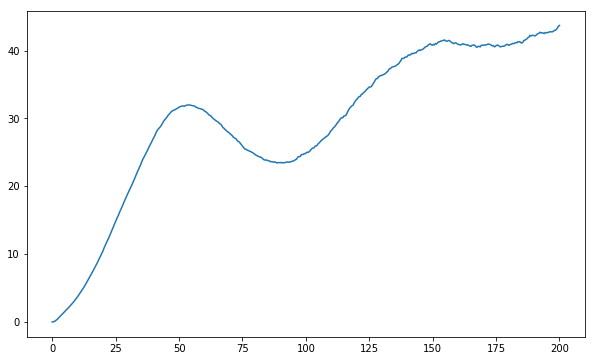

In [12]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(timeax*Gamma, mcresult.expect[-1][1])

In [ ]:
# Export trajectory data to csv
with open('animation_data.csv', 'w', newline = '') as file:
    writer = csv.writer(file, delimiter=',')
    for row in trajectories:
        writer.writerow(row)

In [222]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

# Plot important things
ax[1].plot(timeax*Gamma, mcresult.expect[-1][1])
point, = ax[1].plot(0, 0, 'ro', markersize = 10)

# Some formatting
ax[1].set_xlabel(r'Time ($\Gamma^{-1}$)', fontsize = 15)
ax[1].set_ylabel(r'$\langle (p/\hbar k)^2 \rangle$', fontsize = 15)
ax[1].tick_params(axis='both', which='major', labelsize = 14)

def update_hist(num):
    # Update histogram and move point
    ax[0].clear()
    ax[0].set_xlabel(r'$\langle p/\hbar k \rangle$', fontsize = 15)
    ax[0].tick_params(axis='both', which='major', labelsize = 14)
    ax[0].hist([x[num] for x in trajectories], bins = np.linspace(-10, 10, 50))
    #ax[0].set_yscale('log')
    ax[0].set_ylim(0.01, 500)
    ax[0].set_xlim(-10, 10)
    point.set_data(timeax[num]*Gamma, mcresult.expect[-1][1][num])
    
plt.close(); # Prevent empty axes from showing up

In [223]:
animation.FuncAnimation(fig, update_hist, interval = 50, repeat = True, frames = 500)